# ($\epsilon$, $\delta$)-Differentially Private PLS on NIR of Corn

Author: Ramin Nikzad-Langerodi

This notebook contains accomponying code for the paper "$(\epsilon, \delta)$-Differentially Private Partial Least Squares Regression" by Ramin Nikzad-Langerodi, Du Nguyen Duy and Mathab Alghasi (2024).




In [11]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as rmse, r2_score
from sklearn.model_selection import GridSearchCV

# EDPLS
from diPLSlib.models import EDPLS

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

### Data Set
We will use the Corn data set from Eigenvector Research Inc. The data set contains NIR spectra of corn samples recorded on different infrared spectroscopy instruments along with moisture, oil, protein and starch contents. The data set is available at https://www.eigenvector.com/data/Corn/. 

In [12]:
# Load data
data = sio.loadmat('../data/corn.mat')

# Spectra & Reference values
X = data['m5spec'][0][0]['data']
y = data['propvals'][0][0]['data'][:, 0].reshape(-1, 1)

# Wavelengths
wn = data['m5spec'][0][0][9][1][0][0]

### Accuracy-Pricacy Tradeoff

$(\epsilon, \delta)$-differentially private PLS models with a fixed number of LVs are training with different values of $\epsilon$.


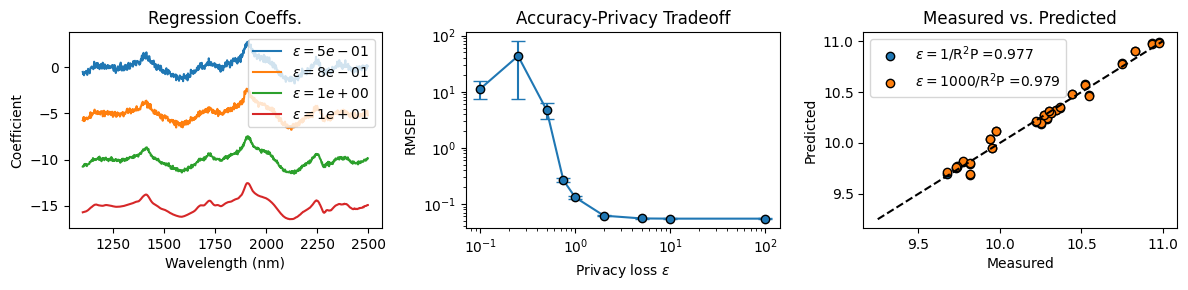

In [13]:
# Preliminaries
eps = [0.5, 0.75, 1, 10]                # epsilon values
bo = 0                                  # baseline offset for plotting
ncomps=5                                # number of components

# Result arrays
EPS=[]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

plt.figure(figsize=(12, 3))
plt.subplot(131)

# Loop over epsilon values
for i in eps:
    
    m = EDPLS(ncomps, epsilon=i, delta=0.05)
    m.fit(X_train, y_train)

    # Compute RMSEP
    ypred = m.predict(X_test)

    # Plot regression coefficients
    plt.plot(wn, m.coef_ + bo)

    EPS.append(f'$\epsilon = {i:.0e}$')
    bo += -5

plt.legend(EPS)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Coefficient')
plt.title('Regression Coeffs.')


### Accuracy-privacy trade-off
plt.subplot(132)
# Define the number of repetitions
num_repetitions = 100

eps = [0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10, 100]

# Initialize arrays to store results
rmsep_results = np.zeros((num_repetitions, len(eps)))
yvar_results = np.zeros((num_repetitions, len(eps)))

# Repeat the experiment 100 times
for rep in range(num_repetitions):
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    RMSEP = []
    YVAR = []
    for i, epsilon in enumerate(eps):
        m = EDPLS(ncomps, epsilon=epsilon, delta=0.05)
        m.fit(X_train, y_train)

        # Compute RMSEP
        ypred = m.predict(X_test)
        rmsep = np.sqrt(rmse(y_test, ypred))
        RMSEP.append(rmsep)

        # Compute Explained Variance
        T = (X_train - X_train.mean(axis=0)) @ (m.x_weights_ @ np.linalg.inv(m.x_loadings_.T @ m.x_weights_))
        xvar = 1 - np.linalg.norm(m.y_residuals_)**2 / np.linalg.norm(m.y_ - m.y_mean_)**2
        YVAR.append(xvar)

    # Store results for this repetition
    rmsep_results[rep, :] = RMSEP
    yvar_results[rep, :] = YVAR

# Compute means and standard errors
rmsep_mean = np.mean(rmsep_results, axis=0)
rmsep_std = np.std(rmsep_results, axis=0) / np.sqrt(num_repetitions)
xvar_mean = np.mean(yvar_results, axis=0)
xvar_std = np.std(yvar_results, axis=0) / np.sqrt(num_repetitions)

# Plot the results
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
blue = default_colors[0]
orange = default_colors[1]

# Plot RMSEP
r = plt.errorbar(eps, rmsep_mean, yerr=rmsep_std, fmt='o-', capsize=5, label='RMSEP', color=blue, mec='k')
#r = plt.plot(eps, rmsep_mean, 'o-', label='RMSEP', color=blue, mec='k')
plt.xlabel('Privacy loss $\epsilon$')
plt.ylabel('RMSEP')
plt.title('RMSEP vs. $\epsilon$')
plt.semilogx()
plt.semilogy()
plt.title('Accuracy-Privacy Tradeoff')


### True vs Predicted at epsilon = 1 and 1000
plt.subplot(133)
epsilon = 1
m = EDPLS(ncomps, epsilon=epsilon, delta=0.05)
m.fit(X_train, y_train)
ypred = m.predict(X_test)
plt.scatter(y_test, ypred, edgecolors='k', label=f'$\epsilon={epsilon}$/R$^2$P =' + str(np.round(r2_score(y_test, ypred),3)))

epsilon = 1000
m = EDPLS(ncomps, epsilon=epsilon, delta=0.05)
m.fit(X_train, y_train)
ypred = m.predict(X_test)
plt.scatter(y_test, ypred, edgecolors='k', label=f'$\epsilon={epsilon}$/R$^2$P =' + str(np.round(r2_score(y_test, ypred),3)))
# Compute R2 score
plt.legend()

plt.plot([9.25, 11], [9.25, 11], 'k--')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs. Predicted')

plt.tight_layout()

plt.show()

### Optimization of the number of LVs given $\epsilon$ and $\delta$


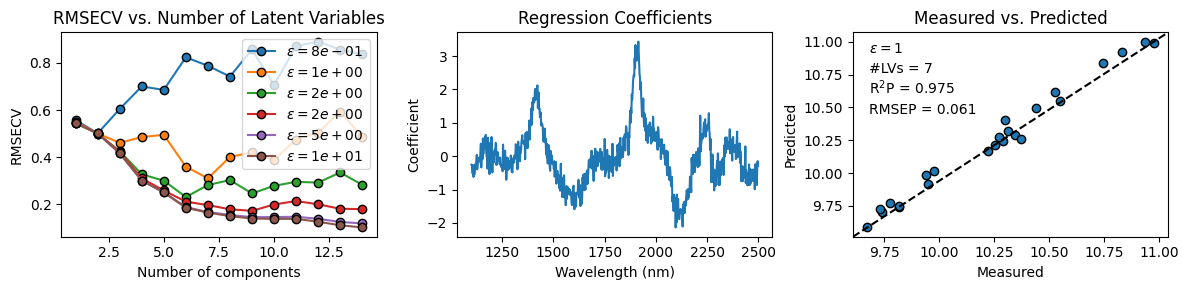

In [14]:
# Define the range of epsilon values
epsilon_values = [0.75, 1, 1.5, 2.5, 5, 10]

results = {}

model = EDPLS(8, epsilon=1, delta=0.05)

# Define the parameter grid
param_grid = {
    'A': np.arange(1, 15)
}

plt.figure(figsize=(12, 3))
plt.subplot(131)
# Loop over the epsilon values
for epsilon in epsilon_values:

    # Initialize the model with the current epsilon
    model = EDPLS(8, epsilon=epsilon, delta=0.05)

    # Define the GridSearchCV object
    gs = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error')

    # Fit the model
    gs.fit(X_train, y_train)

    # Store the results
    results[epsilon] = {
        'param_A': gs.cv_results_['param_A'],
        'mean_test_score': gs.cv_results_['mean_test_score'],
        'std_test_score': gs.cv_results_['std_test_score']
    }


for epsilon in epsilon_values:
    mean_rmse = np.sqrt(-results[epsilon]['mean_test_score'])
    std_rmse = results[epsilon]['std_test_score']
    epsilon_sci = "{:.0e}".format(epsilon)
    #plt.errorbar(results[epsilon]['param_A'], mean_rmse, yerr=std_rmse, fmt='o-', label=f'$\epsilon = {epsilon_sci}$', capsize=2.5, mec='k')
    plt.plot(results[epsilon]['param_A'], mean_rmse, 'o-', label=f'$\epsilon = {epsilon_sci}$', mec='k')


plt.xlabel('Number of components')
plt.ylabel('RMSECV')
#plt.semilogy()
plt.title('RMSECV vs. Number of Latent Variables')
plt.legend(loc='upper right')

### EDPLS model with epsilon = 1 and 7 components
epsilon = 1
ncomps = 7

m = EDPLS(ncomps, epsilon=epsilon, delta=0.05)
m.fit(X_train, y_train)

# Compute RMSEP
ypred = m.predict(X_test)
rmsep = np.sqrt(rmse(y_test, ypred))
r2p = r2_score(y_test, ypred)


# Plot the regression coefficients
plt.subplot(132)
plt.plot(wn, m.coef_)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Coefficient')
plt.title('Regression Coefficients')

# Measured vs. Predicted plot
plt.subplot(133)
plt.scatter(y_test, ypred, edgecolors='k')

# Annotate the plot
plt.annotate(f'$\epsilon = {epsilon}$', (0.05, 0.9), xycoords='axes fraction')
plt.annotate(f'#LVs = {ncomps}', (0.05, 0.8), xycoords='axes fraction')
plt.annotate(f'R$^2$P = {r2p:.3f}', (0.05, 0.7), xycoords='axes fraction')
plt.annotate(f'RMSEP = {rmsep:.3f}', (0.05, 0.6), xycoords='axes fraction')

plt.plot([0, 1], [0, 1], 'k--', transform=plt.gca().transAxes)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs. Predicted')
plt.tight_layout()